<p align="center">
  <img src="https://www.dbs.ie/images/default-source/logos/dbs-logo-2019-small.png" />
</p>
This code is submitted by Yogeshwaran Shanmuganathan as a part of my final dissertation or thesis for the completion of "Master of Science in Data Analytics" at Dublin Business School, Dublin, Ireland.

In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install pyspark
!pip install seaborn

     |████████████████████████████████| 204.2MB 77kB/s 
     |████████████████████████████████| 204kB 47.0MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=90c85a8310caca69448aacb050c7aa9e141bfc6a92ab4b3b8e94ceeba0b5f1fa
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load functionality to manipulate dataframes
from pyspark.sql import functions as fn
import matplotlib.pyplot as plt
from pyspark.sql.functions import stddev, mean, col
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
# Functionality for computing features
from pyspark.ml import feature, regression, classification, Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Tokenizer, VectorAssembler, HashingTF, Word2Vec, StringIndexer, OneHotEncoder
from pyspark.ml import clustering
from itertools import chain
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml import classification
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
import time
#Classification report
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving master.csv to master.csv


In [ ]:
MAX_MEMORY = "45g"

spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

In [ ]:
# load master dataset
dfmaster = spark.read.format("csv").load("master.csv", delimiter = ",", header = True)


Preparations and Understanding before Modeling

In [ ]:
# create a 0/1 column for acquistions
dfmaster = dfmaster.\
  withColumn("labelacq", fn.when(col("status") == "acquired","1").otherwise("0"))

In [ ]:
# number of rows in master table
print(dfmaster.count())

49445


In [ ]:
dfmaster

DataFrame[_c0: string, permalink: string, name: string, market: string, funding_total_usd: string, status: string, country_code: string, city: string, funding_rounds: string, founded_year: string, quarter_new: string, age: string, permalink_agg: string, count_investor: string, time_to_first_funding: string, investor_country_codes: string, funding_round_types: string, total_raised_usd: string, permalink_sub: string, category_final: string, perma: string, investor_country_code: string, permaround: string, funding_round_type: string, labelacq: string]

NAs and market column (with too many levels) handeling

In [ ]:
# check for missing values 
dfmaster.toPandas().isnull().sum()

_c0                           0
permalink                     1
name                          1
market                     3967
funding_total_usd             1
status                     1315
country_code               5273
city                       6116
funding_rounds                1
founded_year              10956
quarter_new               10956
age                       10956
permalink_agg                 1
count_investor                1
time_to_first_funding     24731
investor_country_codes    20954
funding_round_types       17110
total_raised_usd          49435
permalink_sub                 1
category_final            45459
perma                     20954
investor_country_code     20954
permaround                17110
funding_round_type        17110
labelacq                      0
dtype: int64

In [ ]:
# drop market columns because of too many level and better breakdown with the category_final column
dfmaster1 = dfmaster.drop("market")

In [ ]:
dfmaster1 = dfmaster1.toPandas()
dfmaster1

,_c0,permalink,name,funding_total_usd,status,country_code,city,funding_rounds,founded_year,quarter_new,age,permalink_agg,count_investor,time_to_first_funding,investor_country_codes,funding_round_types,total_raised_usd,permalink_sub,category_final,perma,investor_country_code,permaround,funding_round_type,labelacq
0,0,/organization/1lay,1Lay,"1,70,000",operating,None,None,1,2013,Q3,1.5,/organization/1lay,0.0,None,None,None,None,/organization/1lay,None,None,None,None,None,0
1,1,/organization/24pagebooks,24PageBooks,"50,000",closed,USA,Rochester,1,2010,Q1,5.0,/organization/24pagebooks,1.0,1.25,FRA,seed,None,/organization/24pagebooks,None,/organization/24pagebooks,FRA,/organization/24pagebooks,seed,0
2,2,/organization/5min,5min Media,"1,28,00,000",acquired,USA,New York,3,2007,Q1,8.0,/organization/5min,3.0,0.75,"USA, USA, USA","venture, venture, venture",None,/organization/5min,None,/organization/5min,USA,/organization/5min,venture,1
3,3,/organization/abpathfinder,ABPathfinder,"9,60,000",operating,USA,Overland Park,3,2010,Q2,4.75,/organization/abpathfinder,4.0,2.5,"USA, USA, USA","venture, venture, venture, venture",None,/organization/abpathfinder,None,/organization/abpathfinder,USA,/organization/abpathfinder,venture,0
4,4,/organization/acid-labs,Acid Labs,-,operating,USA,Santa Monica,1,2003,Q1,12.0,/organization/acid-labs,0.0,None,None,None,None,/organization/acid-labs,None,None,None,None,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49440,49440,/organization/yieldmo,Yieldmo,"2,21,00,000",operating,USA,New York,3,2012,Q2,2.75,/organization/yieldmo,12.0,0.25,"USA, USA, USA, USA, USA, ISR, USA, USA, USA, U...","venture, venture, venture, venture, venture, v...",None,/organization/yieldmo,None,/organization/yieldmo,USA,/organization/yieldmo,venture,0
49441,49441,/organization/youxinpai,Youxinpai,"3,00,00,000",operating,CHN,Beijing,1,2011,Q3,3.5,/organization/youxinpai,4.0,1.75,"CHN, USA, CHN","venture, venture, venture, venture",None,/organization/youxinpai,None,/organization/youxinpai,CHN,/organization/youxinpai,venture,0
49442,49442,/organization/zeropercent-us,ZeroPercent.us,-,operating,USA,Chicago,1,2011,Q3,3.5,/organization/zeropercent-us,1.0,2.5,USA,seed,None,/organization/zeropercent-us,None,/organization/zeropercent-us,USA,/organization/zeropercent-us,seed,0
49443,49443,/organization/zinch,Zinch,"54,86,842",acquired,USA,Orem,3,2007,Q1,8.0,/organization/zinch,3.0,0.75,"USA, USA","venture, venture, angel",None,/organization/zinch,None,/organization/zinch,USA,/organization/zinch,venture,1


In [ ]:
# Replace NaN with mode for categorical variables
dfmaster1['total_raised_usd'] = dfmaster1['total_raised_usd'].fillna(dfmaster1['total_raised_usd'].mode()[0])
dfmaster1['time_to_first_funding'] = dfmaster1['time_to_first_funding'].fillna(dfmaster1['time_to_first_funding'].mode()[0])
dfmaster1['founded_year'] = dfmaster1['founded_year'].fillna(dfmaster1['founded_year'].mode()[0])
dfmaster1['age'] = dfmaster1['age'].fillna(dfmaster1['age'].mode()[0])
dfmaster1['status'] = dfmaster1['status'].fillna(dfmaster1['status'].mode()[0])
dfmaster1['country_code'] = dfmaster1['country_code'].fillna(dfmaster1['country_code'].mode()[0])
dfmaster1['city'] = dfmaster1['city'].fillna(dfmaster1['city'].mode()[0])
dfmaster1['quarter_new'] = dfmaster1['quarter_new'].fillna(dfmaster1['quarter_new'].mode()[0])
dfmaster1['investor_country_codes'] = dfmaster1['investor_country_codes'].fillna(dfmaster1['investor_country_codes'].mode()[0])
dfmaster1['funding_round_types'] = dfmaster1['funding_round_types'].fillna(dfmaster1['funding_round_types'].mode()[0])
dfmaster1['permaround'] = dfmaster1['permaround'].fillna(dfmaster1['permaround'].mode()[0])
dfmaster1['investor_country_code'] = dfmaster1['investor_country_code'].fillna(dfmaster1['investor_country_code'].mode()[0])
dfmaster1['funding_round_type'] = dfmaster1['funding_round_type'].fillna(dfmaster1['funding_round_type'].mode()[0])
dfmaster1['category_final'] = dfmaster1['category_final'].fillna(dfmaster1['category_final'].mode()[0])
dfmaster1['perma'] = dfmaster1['perma'].fillna(dfmaster1['perma'].mode()[0])

In [ ]:
# check for missing values 
dfmaster1.isnull().sum()

_c0                       0
permalink                 1
name                      1
funding_total_usd         1
status                    0
country_code              0
city                      0
funding_rounds            1
founded_year              0
quarter_new               0
age                       0
permalink_agg             1
count_investor            1
time_to_first_funding     0
investor_country_codes    0
funding_round_types       0
total_raised_usd          0
permalink_sub             1
category_final            0
perma                     0
investor_country_code     0
permaround                0
funding_round_type        0
labelacq                  0
dtype: int64

In [ ]:
# drop rows with missing values
dfmaster1drop = dfmaster1.dropna()

In [ ]:
print(dfmaster1drop.count())

_c0                       49444
permalink                 49444
name                      49444
funding_total_usd         49444
status                    49444
country_code              49444
city                      49444
funding_rounds            49444
founded_year              49444
quarter_new               49444
age                       49444
permalink_agg             49444
count_investor            49444
time_to_first_funding     49444
investor_country_codes    49444
funding_round_types       49444
total_raised_usd          49444
permalink_sub             49444
category_final            49444
perma                     49444
investor_country_code     49444
permaround                49444
funding_round_type        49444
labelacq                  49444
dtype: int64


In [ ]:
sql = SQLContext(spark)

In [ ]:
dfmaster2 = sql.createDataFrame(dfmaster1drop)

In [ ]:
display(dfmaster2)

DataFrame[_c0: string, permalink: string, name: string, funding_total_usd: string, status: string, country_code: string, city: string, funding_rounds: string, founded_year: string, quarter_new: string, age: string, permalink_agg: string, count_investor: string, time_to_first_funding: string, investor_country_codes: string, funding_round_types: string, total_raised_usd: string, permalink_sub: string, category_final: string, perma: string, investor_country_code: string, permaround: string, funding_round_type: string, labelacq: string]

String indexer, one hot encoder and casting to numerics

In [ ]:
# create index for categorical variables
# use pipline to apply indexer
list1 = ["country_code","city","quarter_new","investor_country_code","funding_round_type","category_final"]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(dfmaster2) for column in list1]
pipelineindex = Pipeline(stages=indexers).fit(dfmaster2)
dfmasternew = pipelineindex.transform(dfmaster2)

In [ ]:
# convert string to double for numerical variables
dfmasternew = dfmasternew.\
  withColumn("numeric_funding_rounds", dfmasternew["funding_rounds"].cast("int")).\
  withColumn("numeric_age", dfmasternew["age"].cast("int")).\
  withColumn("numeric_count_investor", dfmasternew["count_investor"].cast("int")).\
  withColumn("numeric_time_to_first_funding", dfmasternew["time_to_first_funding"].cast("int")).\
  withColumn("numeric_total_raised_usd", dfmasternew["total_raised_usd"].cast("int")).\
  withColumn("label", dfmasternew["labelacq"].cast("int"))

In [ ]:
dfmasternew = dfmasternew.\
  withColumn("funding_round_type", dfmasternew["funding_round_type"].cast("double")).\
  withColumn("country_code_index", dfmasternew["country_code_index"].cast("double")).\
  withColumn("city_index", dfmasternew["city_index"].cast("double")).\
  withColumn("quarter_new_index", dfmasternew["quarter_new_index"].cast("double")).\
  withColumn("labelacq", dfmasternew["labelacq"].cast("double"))

In [ ]:
# save
dfone = dfmasternew

In [ ]:
display(dfone)

DataFrame[_c0: string, permalink: string, name: string, funding_total_usd: string, status: string, country_code: string, city: string, funding_rounds: string, founded_year: string, quarter_new: string, age: string, permalink_agg: string, count_investor: string, time_to_first_funding: string, investor_country_codes: string, funding_round_types: string, total_raised_usd: string, permalink_sub: string, category_final: string, perma: string, investor_country_code: string, permaround: string, funding_round_type: double, labelacq: double, country_code_index: double, city_index: double, quarter_new_index: double, investor_country_code_index: double, funding_round_type_index: double, category_final_index: double, numeric_funding_rounds: int, numeric_age: int, numeric_count_investor: int, numeric_time_to_first_funding: int, numeric_total_raised_usd: int, label: int]

In [ ]:
print(dfone.count())

49444


In [ ]:
# list of index columns of categorical variables for the onehotencoder
list2 = dfone.columns[24:30]
list2

['country_code_index',
 'city_index',
 'quarter_new_index',
 'investor_country_code_index',
 'funding_round_type_index',
 'category_final_index']

In [ ]:
# create sparse matrix of indexed categorical columns
# use pipline to apply the encoder
onehotencoder_stages = [OneHotEncoder(inputCol=c, outputCol='onehotencoded_' + c) for c in list2]
pipelineonehot = Pipeline(stages=onehotencoder_stages)
pipeline_mode = pipelineonehot.fit(dfone)
df_coded = pipeline_mode.transform(dfone)

In [ ]:
display(df_coded)

DataFrame[_c0: string, permalink: string, name: string, funding_total_usd: string, status: string, country_code: string, city: string, funding_rounds: string, founded_year: string, quarter_new: string, age: string, permalink_agg: string, count_investor: string, time_to_first_funding: string, investor_country_codes: string, funding_round_types: string, total_raised_usd: string, permalink_sub: string, category_final: string, perma: string, investor_country_code: string, permaround: string, funding_round_type: double, labelacq: double, country_code_index: double, city_index: double, quarter_new_index: double, investor_country_code_index: double, funding_round_type_index: double, category_final_index: double, numeric_funding_rounds: int, numeric_age: int, numeric_count_investor: int, numeric_time_to_first_funding: int, numeric_total_raised_usd: int, label: int, onehotencoded_country_code_index: vector, onehotencoded_city_index: vector, onehotencoded_quarter_new_index: vector, onehotencoded

In [ ]:
print(df_coded.count())

49444


## Additional Analysis with all columns standardized

In [ ]:
# split dataset into training, validaiton and testing dataset
training_df, validation_df, testing_df = df_coded.randomSplit([0.6, 0.3, 0.1])

In [ ]:
training_df.columns[30:35]

['numeric_funding_rounds',
 'numeric_age',
 'numeric_count_investor',
 'numeric_time_to_first_funding',
 'numeric_total_raised_usd']

In [ ]:
training_df.columns[36:42]

['onehotencoded_country_code_index',
 'onehotencoded_city_index',
 'onehotencoded_quarter_new_index',
 'onehotencoded_investor_country_code_index',
 'onehotencoded_funding_round_type_index',
 'onehotencoded_category_final_index']

In [ ]:
# define vector assembler with the features for the modelling
vastd = VectorAssembler(). \
      setInputCols(training_df.columns[30:35] + training_df.columns[36:42]). \
      setOutputCol('features_nonstd')
	  	  
std = feature.StandardScaler(withMean=True, withStd=True).setInputCol('features_nonstd').setOutputCol('features')

In [ ]:
# suffix for investor country code because intersection with county_code of  the companies
invcc = ['{}_{}'.format(a, "investor") for a in indexers[3].labels]

In [ ]:
# define labellist by using the indexer stages for displaying the weights & loadings
labellist = training_df.columns[30:35] + indexers[0].labels + indexers[1].labels + indexers[2].labels + invcc + indexers[4].labels + indexers[5].labels

## Decision Tree

In [ ]:
# define multiclass classification evaluator
mce = MulticlassClassificationEvaluator()

In [ ]:
dt_std = DecisionTreeClassifier(labelCol="label", featuresCol="features")

In [ ]:
dt_pipeline_std = Pipeline(stages=[vastd, std, dt_std]).fit(training_df)

In [ ]:
dfdt_std = dt_pipeline_std.transform(validation_df)

In [ ]:
# print the areas under the curve for the decision tree model pipeline
print("Decision Tree: AUC = {}".format(mce.evaluate(dfdt_std)))

Decision Tree: AUC = 0.8909026137835617


In [ ]:
# print the accuracies for the decision tree model pipeline
print(dfdt_std.select(fn.expr('float(label = prediction)').alias('correct')).select(fn.avg('correct').alias("Accuracy for Decision Tree")).show())

+--------------------------+
|Accuracy for Decision Tree|
+--------------------------+
|        0.9258809234507898|
+--------------------------+

None


## Gradient Boosted Trees

In [ ]:
gbt_std = GBTClassifier(labelCol="label", featuresCol="features", maxIter=100)

In [ ]:
gbt_pipeline_std = Pipeline(stages=[vastd, std, gbt_std]).fit(training_df)

In [ ]:
dfgbt_std = gbt_pipeline_std.transform(validation_df)

In [ ]:
# print the areas under the curve for the gradient boosted trees model pipeline
print("Gradient Boosted Trees: AUC = {}".format(mce.evaluate(dfgbt_std)))

Gradient Boosted Trees: AUC = 0.8942996259784223


In [ ]:
# print the accuracies for the gradient boosted trees model pipeline
print(dfgbt_std.select(fn.expr('float(label = prediction)').alias('correct')).select(fn.avg('correct').alias("Accuracy for Gradient Boosted Tree")).show())

+----------------------------------+
|Accuracy for Gradient Boosted Tree|
+----------------------------------+
|                0.9233157823680302|
+----------------------------------+

None


## Random Forest 25 trees

In [ ]:
# define binary classification evaluator
bce = BinaryClassificationEvaluator()

In [ ]:
rfstd = RandomForestClassifier(numTrees=25, maxBins=10000, featuresCol='features', labelCol='label')
rf_pipeline_std = Pipeline(stages=[vastd, std, rfstd]).fit(training_df)
dfrf_std = rf_pipeline_std.transform(validation_df)
print("Random Forest 25 trees: AUC = {}".format(bce.evaluate(dfrf_std)))
print(dfrf_std.select(fn.expr('float(label = prediction)').alias('correct')).select(fn.avg('correct').alias("Accuracy for Random Forest with 25 trees")).show())
rfw_std = spark.createDataFrame(pd.DataFrame(list(zip(labellist, rf_pipeline_std.stages[2].featureImportances.toArray())),
            columns = ['column', 'importancy']).sort_values('importancy').tail(20))

Random Forest 25 trees: AUC = 0.6864552327753096
+----------------------------------------+
|Accuracy for Random Forest with 25 trees|
+----------------------------------------+
|                      0.9260159308761982|
+----------------------------------------+

None


In [ ]:
rfw_std.show()

+--------------------+--------------------+
|              column|          importancy|
+--------------------+--------------------+
|          Landenberg|0.016242934891486784|
|        KWT_investor|0.016905400556295292|
|        Minas Gerais|0.017528464871616672|
|San Crist�bal De ...|0.018471036142936742|
|       Qiryat Bialik|0.019402621489931264|
|                 CHN|0.019921364469908512|
|              Bochum| 0.02018478893714758|
|                 LBN|0.020245644483537228|
|          Carrollton|0.021958103342365778|
|             Atlanta| 0.02290499304879503|
|              Lititz| 0.02323579731000083|
|numeric_count_inv...|0.024323614581904143|
|           Singapore|0.024839062482074473|
|   Frankfurt Am Main| 0.02561825967051216|
|        MAR_investor|0.025737880131396777|
|numeric_funding_r...|  0.0325456223583157|
|             Toronto| 0.04137080175091696|
|                 USA| 0.04289544566321536|
|numeric_time_to_f...|0.045841620601393816|
|         numeric_age| 0.1010769

## Logistic Regression

In [ ]:
lambda_par_std = 0.05
alpha_par_std = 0.05
en_lr_std = LogisticRegression().\
        setLabelCol('label').\
        setFeaturesCol('features').\
        setRegParam(lambda_par_std).\
        setElasticNetParam(alpha_par_std)

In [ ]:
en_lr_estimator_std = Pipeline(stages=[vastd, std, en_lr_std])
en_lr_model_std = en_lr_estimator_std.fit(training_df)
dfmodel_std = en_lr_model_std.transform(validation_df)
print("Logistic Regression Model: AUC = {}".format(bce.evaluate(dfmodel_std)))	
print(dfmodel_std.select(fn.expr('float(label = prediction)').alias('correct')).select(fn.avg('correct').alias("Accuracy for Model")).show())

Logistic Regression Model: AUC = 0.7213977014056865
+------------------+
|Accuracy for Model|
+------------------+
|0.9250708788983394|
+------------------+

None


In [ ]:
pd.DataFrame(list(zip(labellist, en_lr_model_std.stages[2].coefficients.toArray())),
            columns = ['label', 'weight']).sort_values('weight').tail(40)

,label,weight
3311,Maroubra,0.016099
3278,Mafra,0.016179
2179,Wollongong,0.016440
167,Waltham,0.016720
741,Haryana,0.017195
2610,Cottage Grove,0.017298
1356,Grayslake,0.017912
123,Palo Alto,0.017962
160,Irvine,0.018345
1254,Alamo,0.020098


In [ ]:
pd.DataFrame(list(zip(labellist, en_lr_model_std.stages[2].coefficients.toArray())),
            columns = ['label', 'weight']).sort_values('weight').head(10)

,label,weight
4387,MAR_investor,-0.067191
4312,USA_investor,-0.044475
11,IND,-0.022970
4392,undisclosed,-0.022935
8,CHN,-0.020628
4316,DEU_investor,-0.019393
130,San Diego,-0.006592
4314,FRA_investor,-0.006346
164,Mumbai,-0.005647
14,RUS,-0.004942


## Neural Networks

In [ ]:
# define evaluators for accuracy and area under the curve
evaluator = evaluation.MulticlassClassificationEvaluator(metricName="accuracy")
evaluatorauc = evaluation.MulticlassClassificationEvaluator()

mlp_std = classification.MultilayerPerceptronClassifier(seed=0).\
    setStepSize(0.2).\
    setMaxIter(200).\
    setFeaturesCol('features').\
    setLayers([4399,30,30,30, 2])
	
mlp_std_model = Pipeline(stages=[vastd, std, mlp_std]).fit(training_df)
dfnn_std = mlp_std_model.transform(validation_df)
print("NN Model with 3 hidden layers and 30 neurons each: Accuracy = {}".format(evaluator.evaluate(dfnn_std)))
print("NN Model with 3 hidden layers and 30 neurons each: AUC = {}".format(evaluatorauc.evaluate(dfnn_std)))

NN Model with 3 hidden layers and 30 neurons each: Accuracy = 0.9019171054407993
NN Model with 3 hidden layers and 30 neurons each: AUC = 0.8908697172035627



## PCA + Logistic Regression

In [ ]:
pca_std = feature.PCA(k=1500, inputCol='features', outputCol='pca_feat')
en_lr_estimator_std_pca = Pipeline(
    stages=[vastd, std, pca_std, en_lr_std])
en_lr_model_std_pca = en_lr_estimator_std_pca.fit(training_df)
varlist_std =en_lr_model_std_pca.stages[2].explainedVariance
npvar_std = np.cumsum(varlist_std[1000:1500])
# 0.7 as starting point because we start at 1000
# was found in other analysis
npvar_std = [x+0.7 for x in npvar_std]
pci_std = [pci_std for pci_std in range(1000,1500,1)]
dfvar_std = spark.createDataFrame(pd.DataFrame({"Number of PCs": pci_std, "Cumlative Variance Explained": npvar_std}))
display(dfvar_std)

DataFrame[Number of PCs: bigint, Cumlative Variance Explained: double]

In [ ]:
dfvar_std.show()

+-------------+----------------------------+
|Number of PCs|Cumlative Variance Explained|
+-------------+----------------------------+
|         1000|          0.7002912349900158|
|         1001|          0.7005824699800317|
|         1002|          0.7008737049700475|
|         1003|          0.7011649399600633|
|         1004|          0.7014561749500793|
|         1005|          0.7017474099400951|
|         1006|          0.7020386449301109|
|         1007|          0.7023298799201269|
|         1008|          0.7026211149101427|
|         1009|          0.7029123499001585|
|         1010|          0.7032035848901743|
|         1011|          0.7034948198801902|
|         1012|          0.7037860548702061|
|         1013|          0.7040772898602219|
|         1014|          0.7043685248502377|
|         1015|          0.7046597598402536|
|         1016|          0.7049509948302695|
|         1017|          0.7052422298202853|
|         1018|          0.7055334648103011|
|         

In [ ]:
pca_std = feature.PCA(k=1332, inputCol='features', outputCol='pca_feat')
en_lr_std_pca = LogisticRegression().\
        setLabelCol('label').\
        setFeaturesCol('pca_feat').\
        setRegParam(lambda_par_std).\
        setElasticNetParam(alpha_par_std)
en_lr_estimator_std_pca = Pipeline(
    stages=[vastd, std, pca_std, en_lr_std])
en_lr_model_std_pca = en_lr_estimator_std_pca.fit(training_df)
dfmodel_std_pca = en_lr_model_std_pca.transform(validation_df)

In [ ]:
print("Logistic Regression Model: AUC = {}".format(bce.evaluate(dfmodel_std_pca)))
print(dfmodel_std_pca.select(fn.expr('float(label = prediction)').alias('correct')).select(fn.avg('correct').alias("Accuracy for Model 1")).show())

Logistic Regression Model: AUC = 0.7214443261716983
+--------------------+
|Accuracy for Model 1|
+--------------------+
|  0.9250708788983394|
+--------------------+

None


In [ ]:
pc1 = en_lr_model_std_pca.stages[2].pc.toArray()[:, 0].tolist()
pc2 = en_lr_model_std_pca.stages[2].pc.toArray()[:, 1].tolist()
# create pandas df with the loadings/PCs and the corresponding labels
pc_loadings = pd.DataFrame([labellist, pc1, pc2]).T.rename(columns={0: 'label', 
                                                                          1: 'load_pc1',
                                                                          2: 'load_pc2',})

In [ ]:
load1 = spark.createDataFrame(pd.concat((pc_loadings.sort_values('load_pc1').head(), 
           pc_loadings.sort_values('load_pc1').tail())))
display(load1)

DataFrame[label: string, load_pc1: double, load_pc2: double]

In [ ]:
# create spark df with the 5 highest and lowest loadings of the second PC
load2 = spark.createDataFrame(pd.concat((pc_loadings.sort_values('load_pc2').head(), 
           pc_loadings.sort_values('load_pc2').tail())))
display(load2)

DataFrame[label: string, load_pc1: double, load_pc2: double]

# Testing Performance

In [ ]:
print("Decision Tree Classifier")
# Decision Tree Classifier
dfdt_test_std = dt_pipeline_std.transform(testing_df)
print("Decision Tree: AUC = {}".format(mce.evaluate(dfdt_test_std)))
print(dfdt_test_std.select(fn.expr('float(label = prediction)').alias('correct')).select(fn.avg('correct').alias("Accuracy for Decision Tree")).show())
auc_dt = mce.evaluate(dfdt_test_std)

Decision Tree Classifier
Decision Tree: AUC = 0.8850931565774143
+--------------------------+
|Accuracy for Decision Tree|
+--------------------------+
|         0.921808185705559|
+--------------------------+

None


In [ ]:
dts_true = dfdt_test_std.select(['label']).collect()
dts_pred = dfdt_test_std.select(['prediction']).collect()
print(classification_report(dts_true, dts_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4527
           1       0.50      0.01      0.01       384

    accuracy                           0.92      4911
   macro avg       0.71      0.50      0.48      4911
weighted avg       0.89      0.92      0.89      4911



In [ ]:
print("Gradient Boosted Trees Classifier")
# Gradient Boosted Trees Classifier
dfgbt_test_std = gbt_pipeline_std.transform(testing_df)
print("Gradient Boosted Trees: AUC = {}".format(mce.evaluate(dfgbt_test_std)))
print(dfgbt_test_std.select(fn.expr('float(label = prediction)').alias('correct')).select(fn.avg('correct').alias("Accuracy for Gradient Boosted Trees")).show())
auc_gbt = mce.evaluate(dfgbt_test_std)

Gradient Boosted Trees Classifier
Gradient Boosted Trees: AUC = 0.8886799759221228
+-----------------------------------+
|Accuracy for Gradient Boosted Trees|
+-----------------------------------+
|                 0.9191610669924659|
+-----------------------------------+

None


In [ ]:
gbts_true = dfgbt_test_std.select(['label']).collect()
gbts_pred = dfgbt_test_std.select(['prediction']).collect()
print(classification_report(gbts_true, gbts_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4527
           1       0.36      0.04      0.07       384

    accuracy                           0.92      4911
   macro avg       0.64      0.52      0.52      4911
weighted avg       0.88      0.92      0.89      4911



In [ ]:
print("Random Forest Model with 25 trees")
# Random Forest Model with 25 trees
dfrf_std_test = rf_pipeline_std.transform(testing_df)
print("Random Forest 25 trees: AUC = {}".format(bce.evaluate(dfrf_std_test)))
print(dfrf_std_test.select(fn.expr('float(label = prediction)').alias('correct')).select(fn.avg('correct').alias("Accuracy for Random Forest with 25 trees")).show())
auc_rf = bce.evaluate(dfrf_std_test)

Random Forest Model with 25 trees
Random Forest 25 trees: AUC = 0.7018628966939106
+----------------------------------------+
|Accuracy for Random Forest with 25 trees|
+----------------------------------------+
|                       0.921808185705559|
+----------------------------------------+

None


In [ ]:
rfs_true = dfrf_std_test.select(['label']).collect()
rfs_pred = dfrf_std_test.select(['prediction']).collect()
print(classification_report(rfs_true, rfs_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4527
           1       0.00      0.00      0.00       384

    accuracy                           0.92      4911
   macro avg       0.46      0.50      0.48      4911
weighted avg       0.85      0.92      0.88      4911



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Logistic Regression Model with PCA")
# Logistic Regression Model with PCA
dfmodel_std_pca_test = en_lr_model_std_pca.transform(testing_df)
print("Logistic Regression Model: AUC = {}".format(bce.evaluate(dfmodel_std_pca_test)))
print(dfmodel_std_pca_test.select(fn.expr('float(label = prediction)').alias('correct')).select(fn.avg('correct').alias("Accuracy for Logistic Regression Model")).show())
auc_lr = bce.evaluate(dfmodel_std_pca_test)

Logistic Regression Model with PCA
Logistic Regression Model: AUC = 0.7306519678226944
+--------------------------------------+
|Accuracy for Logistic Regression Model|
+--------------------------------------+
|                    0.9207900631236001|
+--------------------------------------+

None


In [ ]:
lrs_true = dfmodel_std_pca_test.select(['label']).collect()
lrs_pred = dfmodel_std_pca_test.select(['prediction']).collect()
print(classification_report(lrs_true, lrs_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4527
           1       0.00      0.00      0.00       384

    accuracy                           0.92      4911
   macro avg       0.46      0.50      0.48      4911
weighted avg       0.85      0.92      0.88      4911



In [ ]:
print("Neural Network Model")
# Neural Network Model
dfnntest_std = mlp_std_model.transform(testing_df)
print("NN Model with 3 hidden layers and 30 neurons each: Accuracy = {}".format(evaluator.evaluate(dfnntest_std)))
print("NN Model with 3 hidden layers and 30 neurons each: AUC = {}".format(evaluatorauc.evaluate(dfnntest_std)))
auc_nn = evaluatorauc.evaluate(dfnntest_std)

Neural Network Model
NN Model with 3 hidden layers and 30 neurons each: Accuracy = 0.8910608837304012
NN Model with 3 hidden layers and 30 neurons each: AUC = 0.8798474813774612


In [ ]:
nns_true = dfnntest_std.select(['label']).collect()
nns_pred = dfnntest_std.select(['prediction']).collect()
print(classification_report(nns_true, nns_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      4527
           1       0.19      0.12      0.15       384

    accuracy                           0.89      4911
   macro avg       0.56      0.54      0.55      4911
weighted avg       0.87      0.89      0.88      4911



## Model Comparison

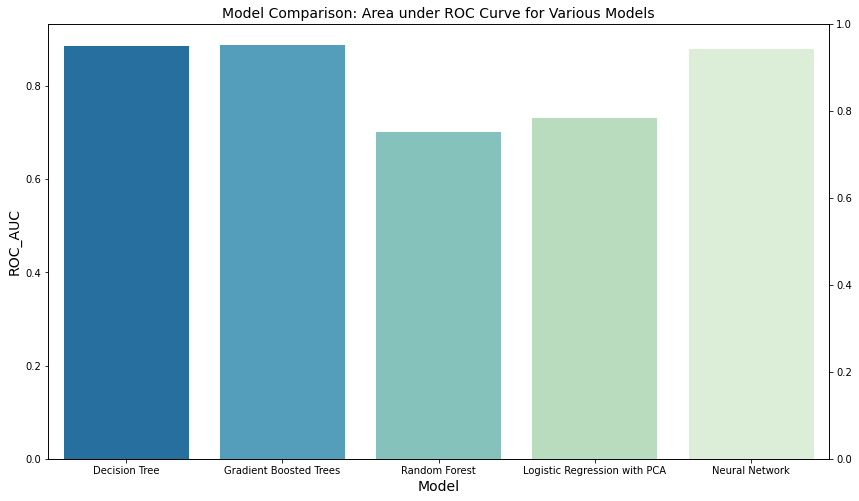

In [ ]:
roc_auc_scores = [auc_dt, auc_gbt, auc_rf, auc_lr, auc_nn]

model_data = {'Model': ['Decision Tree','Gradient Boosted Trees','Random Forest','Logistic Regression with PCA','Neural Network'],
              'ROC_AUC': roc_auc_scores}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(14,8))
ax1.set_title('Model Comparison: Area under ROC Curve for Various Models', fontsize=14)
ax1.set_xlabel('Model', fontsize=14)
ax1.set_ylabel('ROC_AUC', fontsize=14)
ax2 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='GnBu_r')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()

With all columns standardized, we come to the same conclusion.

The AUC and accuracy increased for every model in comparison to the validation performance. Random forest seems to have the best accuracy while having the worst AUC, which should raise a red flag and would require further analyses and explanations. Neural networks perform the best overall with a huge increase in the AUC value in comparison to the other models.

So it would also be worth it to really try to increase those numbers further with the optimal number of hidden layers and neurons here.

However, the performance of the models seems to be a little worse than the performance when only standardizing the numerical features, but it is not significant.